#### **本节介绍全卷积神经网络**

全卷积神经网络可以用于语义分割，其简单模型架构如下：

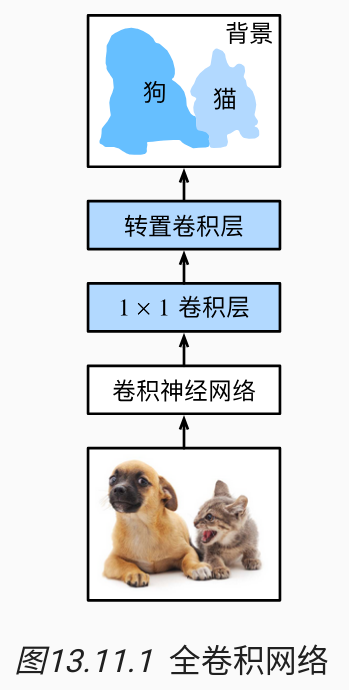


**对于转置卷积我的理解：对于转置卷积的输入、输出shape计算，用重叠思想计算**

下面是过程推导：

**(1)**

假设输入图片大小为$H_0$、$W_0$，转置卷积核大小为$K_h$、$K_w$，步幅为$stride$ 

对$H_0$方向考虑，相邻两个卷积核产生的广义像素$H_0$方向重叠长度为$H_0 - stride$  

那么最终输出图像在$H_0$方向上的长度为

$$
\begin{align}
    H^{'} &= H_0 * K_h - (H_0 - 1) * (K_h - stride) \nonumber \\
    &= H_0 * stride + K_h - stride \nonumber \\
    &= (H_0 - 1) * stride + K_h \nonumber \\
\end{align}
$$

把$stride$ = 1代入测试，得到$H^{'} = H_0 + K_h - 1$，符合预期.

对$W_0$方向同理.

**(2)**

加上填充$padding$的话也没有难度，填充$padding$在转置卷积中是删除，与卷积的切好相反，故最终输出为
$$D^{'} = (D_0 - 1) * stride + K_d - 2 * padding$$

**有了理论基础，下面便可进行全卷积网络的搭建了，我会以一张自己的图片为例子，对一张图片进行分割训练，哪怕其过拟合**

In [21]:
import cv2
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from d2l import torch as d2l # 非必要不要

**零、模型使用确定**

In [22]:
# 导入预训练好的shufflenet(比resnet更轻量化)模型的前部分作为分割模型的卷积网络部分
# pretrained_net = torchvision.models.shufflenet_v2_x1_0(pretrained = True)
pretrained_net = torchvision.models.resnet18(pretrained = True)
print(len(list(pretrained_net.children())))
print(list(pretrained_net.children())[-3:]) # 查看后几层

10
[Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, e

In [23]:
net = nn.Sequential(*list(pretrained_net.children())[:-2]) # 去掉最后的最大池化与全连接层
print(net[0]) # 查看第一层需要的输入数据格式：二维卷积即要求输入格式为(批量，通道，H，W)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


**一、数据集、数据预处理**

In [24]:
dataset_dir = 'E:/My_note_book/torch_learning/semantic_segmentation/images'

# 生成训练样本
img = cv2.imread(os.path.join(dataset_dir,'4052_o.jpg'))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # 转RGB
feature_single = torch.tensor(img)
# train_data = train_data.permute(2,0,1).unsqueeze(0) # 3维转4维度(包含批尺度，此处批大小为1)，可输入网络的样本
feature_single = feature_single.permute(2,0,1) # 先不转4维
features = [feature_single] # 数据压缩到列表，符合后续数据集生成
print(feature_single.shape) # torch.Size([1, 3, 319, 500])

# 加载上面样本的标签
img = cv2.imread(os.path.join(dataset_dir,'4052_l.png'))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # 转RGB
label_single = torch.tensor(img)
label_single = label_single.permute(2,0,1)
labels = [label_single]
print(label_single.shape) # torch.Size([3, 319, 500])

torch.Size([3, 319, 500])
torch.Size([3, 319, 500])


In [25]:
# 要分割任务分割颜色
"""注意是RGB格式!!!!"""
color_map = [[0,0,0],[128,0,0]] # 简单测试，仅有两类
classes = ['background','plane']

In [26]:
#@
def my_colormap2label():
    """构建RGB到分割任务的类别索引"""
    colormap2label = torch.zeros(256**3,dtype = torch.long)
    for i,color in enumerate(color_map):
        colormap2label[color[0]*256*256 + color[1]*256 + color[2]] = i
    return colormap2label

#@
def my_label_indices(data,colormap2label):
    """将标签中的RGB值映射到对应的类别索引
    输入：
        data：输入图像数据，单张输入
    输出：
        colormap2label[idx]，返回对应位置每个像素的类别
    """
    # print(data.shape)
    data = data.permute(1,2,0).numpy().astype('int32') # 将输入数据转化图片的(H,W,C)格式，因为之前为了适应网络输入转换成其他了
    # print(data.shape)
    idx = data[:,:,0] * 256 * 256 + data[:,:,1] * 256 + data[:,:,2]
    return colormap2label[idx]
    

In [27]:
# 测试
test = np.array([1,2,3,4])
x = np.array([[1,2,3],[0,1,3],[2,1,2]])
y = test[x]
print(y.shape)

(3, 3)


In [28]:
# 检测飞机对应分割区域是否被成功打上对应的类别索引
y = my_label_indices(labels[0],my_colormap2label())
print(y[154:175,161:219])

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


In [29]:
#@save
def rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像
    输入：
        feature：特征图像
        label：标签图像
        height、width：裁剪的大小
    """
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

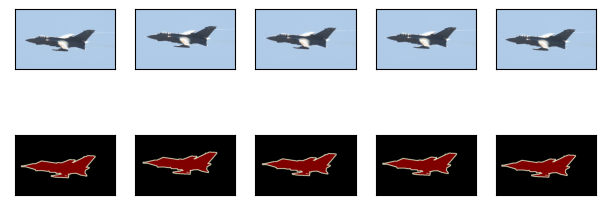

In [30]:
height,width = 288,480
imgs = []
for i in range(5):
    imgs += rand_crop(features[0],labels[0],height,width)

imgs = [img.permute(1,2,0) for img in imgs] # 转化为可展示格式
d2l.show_images(imgs[::2] + imgs[1::2], 2, 5)

In [31]:
#@save
class MySegDataset(torch.utils.data.Dataset):
    """一个用于加载"自己的数据集的":自定义数据集"""

    def __init__(self, crop_size):
        """
        crop_size : 将数据集裁剪的大小
        """
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # RGB值标准化
        self.crop_size = crop_size
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = my_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, my_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [32]:
crop_size = (288, 480)
train_data = MySegDataset(crop_size) # 测试，预期结果：1个数据

read 1 examples


In [33]:
batch_size = 1
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=0) # num_workers为读取数据集的进程数
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    print(Y.squeeze(0)[154:175,161:219])
    break

torch.Size([1, 3, 288, 480])
torch.Size([1, 288, 480])
tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])


**三、模型搭建**

In [34]:
# net = nn.Sequential(*list(pretrained_net.children())[:-1]) # 去掉shufflenet_v2_x1_0最后一层的全连接层
net = nn.Sequential(*list(pretrained_net.children())[:-2]) # 去掉最后的最大池化与全连接层
print(len(net))
print(net[-1])

8
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps

In [37]:
# 测试网络卷积部分的前向传播
X = torch.rand(1,3,288,480)
print(net(X).shape) # 发现resnet18的卷积部分与shufflenet的卷积部分有相同点：将输入图长宽缩短到1/32

torch.Size([1, 2, 288, 480])


In [36]:
num_classes = 2 # 待分割的有两类，对应len(colormap)
net.add_module('final_conv',nn.Conv2d(512,num_classes,kernel_size = 1)) # 1x1卷积另类全连接
net.add_module('transpose_conv',nn.ConvTranspose2d(num_classes,num_classes,
                                   kernel_size = 64,padding = 16,stride = 32)) # 转置卷积层恢复图像原大小

In [38]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

让我们用[**双线性插值的上采样实验**]它由转置卷积层实现。
我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用`bilinear_kernel`函数初始化。


In [39]:
# 测试将高、宽放大2倍的转置卷积层
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));
print(feature_single.shape)
X = torch.tensor(feature_single.numpy().astype('float32'))
X = X.unsqueeze(0)
print(X.shape)
Y = conv_trans(X)
print(Y.shape)
# 放大两倍

torch.Size([3, 319, 500])
torch.Size([1, 3, 319, 500])
torch.Size([1, 3, 638, 1000])


全卷积网络[**用双线性插值的上采样初始化转置卷积层。对于$1\times 1$卷积层，我们使用Xavier初始化参数。**]

In [40]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W) # 初始化转置卷积层

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [41]:
# 读取数据集
batch_size = 1 # 因为数据集中只有一个数据，batch_size只能取1
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=0) # num_workers为读取数据集的进程数

# 其中train_data是来自MySegDataset类，包括了对应的features与labels

for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([1, 3, 288, 480])
torch.Size([1, 288, 480])


In [42]:
# 定义网络的损失函数
def loss(inputs,targets):
    return F.cross_entropy(inputs,targets,reduction='none').mean(1).mean(1)

num_epochs,lr,wd,device = 1000,0.001,1e-3,d2l.try_gpu()
trainer = torch.optim.SGD(net.parameters(),lr = lr,weight_decay = wd)

In [63]:
# 训练
net = net.to(device)
use_times = 0
plt_loss = []
for epoch in range(num_epochs):
    start = time.perf_counter() # 相比time.time()更加精确
    net.train() # 切换回训练模式
    loss_save = 0
    for feature,target in train_iter:
        # 清空梯度
        trainer.zero_grad()

        # 切换硬件
        X = feature.to(device)
        Y = target.to(device)

        # 前向传播
        y_pred = net(X)
        _loss = loss(y_pred,Y)
        loss_save += _loss.item()

        # 反向传播及更新梯度
        _loss.backward()
        trainer.step()
    loss_save = loss_save / len(train_iter)
    plt_loss.append(loss_save)
    end = time.perf_counter()
    print(f"epoch{epoch} use time:{end-start}!")
    use_times += end - start

epoch0 use time:0.2761222999997699!
epoch1 use time:0.21464910000031523!
epoch2 use time:0.24689630000102625!
epoch3 use time:0.22961519999989832!
epoch4 use time:0.22418849999849044!
epoch5 use time:0.2095355000001291!
epoch6 use time:0.22016059999987192!
epoch7 use time:0.22558890000073006!
epoch8 use time:0.24720689999958267!
epoch9 use time:0.2563563999992766!
epoch10 use time:0.302697300001455!
epoch11 use time:0.3038663999996061!
epoch12 use time:0.31480440000086674!
epoch13 use time:0.30368239999916113!
epoch14 use time:0.31487879999986035!
epoch15 use time:0.28469679999943764!
epoch16 use time:0.31147649999911664!
epoch17 use time:0.2800263000008272!
epoch18 use time:0.28764810000029684!
epoch19 use time:0.2888258000002679!
epoch20 use time:0.2829538000005414!
epoch21 use time:0.32537410000077216!
epoch22 use time:0.29460479999943345!
epoch23 use time:0.2719978999994055!
epoch24 use time:0.26882579999983136!
epoch25 use time:0.28458280000086233!
epoch26 use time:0.2919879999990

Model train use 28.107136399996307 seconds


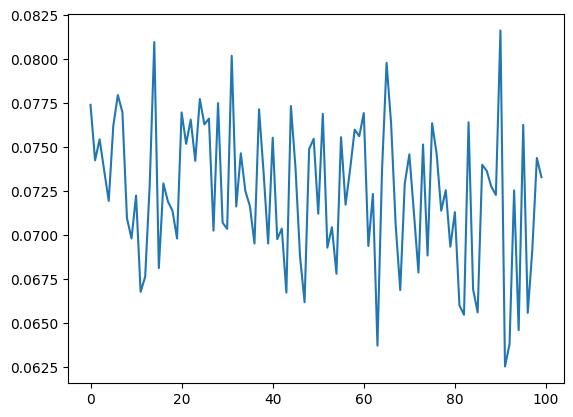

In [64]:
print(f"Model train use {use_times} seconds")
plt.plot(np.arange(0,len(plt_loss),1),plt_loss)
plt.show()

In [43]:
def predict(img):
    """预测函数
    输入：
        img : 待分割的图像
    """
    img = torch.tensor(img.clone().detach(),dtype=torch.float32)
    img = img.unsqueeze(0) # 转化为可输入网络格式
    pred = net(img.to(device)).argmax(dim = 1)
    pred = pred.squeeze(0)
    return pred

def idc2color(img):
    """类别标签图像反映射回RGB颜色
    输入：
        img : 待恢复颜色的图像(H,W)
    输出：
        img : (H,W,通道)
    """
    temp = img.clone().detach().numpy()
    map_tensor = torch.tensor(color_map,dtype = torch.float32)
    img = map_tensor[temp]
    return img


In [65]:
img_o,img_l = rand_crop(features[0],labels[0],height,width)
img_pred = predict(img_o)
img_pred_color = idc2color(img_pred)

C:\Users\28718\AppData\Local\Temp\ipykernel_41232\582567209.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img.clone().detach(),dtype=torch.float32)


In [66]:
img_o = img_o.permute(1,2,0).numpy()
img_l = img_l.permute(1,2,0).numpy()
img_pred_color = img_pred_color.numpy()
print(img_pred_color.shape)
img_origin = cv2.cvtColor(img_o,cv2.COLOR_RGB2BGR) # 原始可展示图像
img_label = cv2.cvtColor(img_l,cv2.COLOR_RGB2BGR) # 正确标签可展示图像
img_ans = cv2.cvtColor(img_pred_color,cv2.COLOR_RGB2BGR) # 预测分割可展示图像
cv2.imshow('Origin',img_origin)
cv2.imshow('Label',img_label)
cv2.imshow('Segment',img_ans)
cv2.waitKey(0)
cv2.destroyAllWindows()

(288, 480, 3)
